In [4]:
import os
import datetime
import squarify
import warnings
import pandas as pd 
import numpy as np
import datetime as dt
from operator import attrgetter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
palette = 'Set2'

In [5]:


df = pd.read_csv(r"./data.csv",
                 header = 0,
                 encoding = 'unicode_escape',
                 dtype = {'CustomerID': str,
                          'InvoiceID': str},
                 parse_dates = ['InvoiceDate'], 
                 infer_datetime_format = True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [6]:
def check_data(dataframe, head=5):
    print(" SHAPE ".center(70,'-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'-'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'-'))
    print(dataframe.head(head))
    print(" TAIL ".center(70,'-'))
    print(dataframe.tail(head))
    print(" MISSING VALUES ".center(70,'-'))
    print(dataframe.isnull().sum())
    print(" DUPLICATED VALUES ".center(70,'-'))
    print(dataframe.duplicated().sum())
    print(" QUANTILES ".center(70,'-'))
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1], numeric_only = True).T)
    
check_data(df)

------------------------------- SHAPE --------------------------------
Rows: 541909
Columns: 8
------------------------------- TYPES --------------------------------
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object
-------------------------------- HEAD --------------------------------
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 0

In [7]:
df[df['InvoiceNo'].str.contains('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


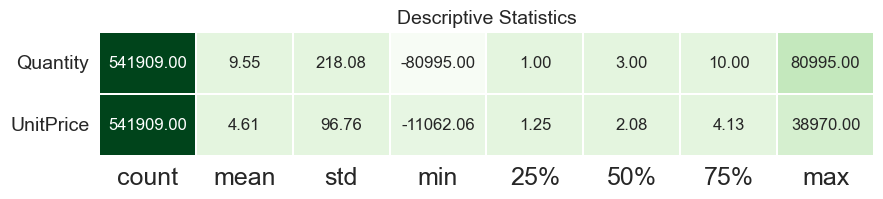

In [8]:
def desc_stats(dataframe):
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= dataframe.describe().T.columns,
                           data= dataframe.describe().T)
    
    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0] * 0.81))
    sns.heatmap(desc_df,
                annot = True,
                cmap = "Greens",
                fmt = '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.1,
                cbar = False,
                annot_kws = {"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(df.select_dtypes(include = [float, int]))

In [9]:
def replace_with_thresholds(dataframe, variable, q1 = 0.25, q3 = 0.75):
    
    '''
    Detects outliers with IQR method and replaces with thresholds 
    
    '''
    
    df_ = dataframe.copy()
    quartile1 = df_[variable].quantile(q1)
    quartile3 = df_[variable].quantile(q3)
    iqr = quartile3 - quartile1
    
    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    df_.loc[(df_[variable] < low_limit), variable] = low_limit
    df_.loc[(df_[variable] > up_limit), variable] = up_limit
    
    return df_

def ecommerce_preprocess(dataframe):
    df_ = dataframe.copy()
    
    # missing values
    df_ = df_.dropna()
    
    # cancelled order, negative quantity
    df_ = df_[~df_['InvoiceNo'].str.contains('C', na = False)]
    df_ = df_[df_['Quantity'] > 0]
    
    # outlier adjustment
    df_ = replace_with_thresholds(df_, "Quantity", q1 = 0.01, q3 = 0.99)
    df_ = replace_with_thresholds(df_, "UnitPrice", q1 = 0.01, q3 = 0.99)
    
    #Total Price
    df_["TotalPrice"] = df_["Quantity"] * df_["UnitPrice"]
    
    return df_

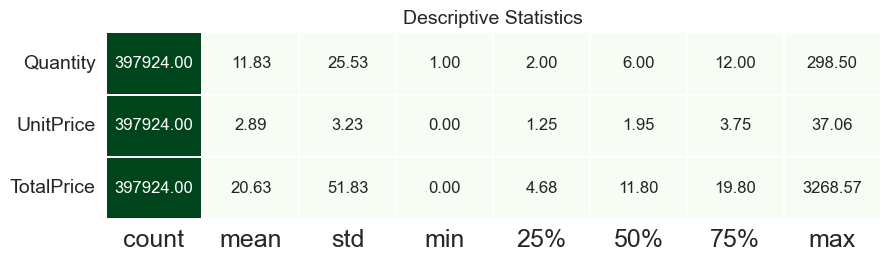

In [10]:
df = ecommerce_preprocess(df)

desc_stats(df.select_dtypes(include = [float, int]))

In [11]:
print(df['InvoiceDate'].max())

2011-12-09 12:50:00


In [12]:
today_date = dt.datetime(2011,12,11)

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (today_date - x.max()).days,
                                    'InvoiceNo': lambda x: x.nunique(),
                                    'TotalPrice': lambda x: x.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']
rfm.loc[rfm['monetary'] <= 0, 'monetary'] = 0
rfm = rfm.reset_index()

print(rfm)

     CustomerID  recency  frequency  monetary
0         12346      326          1    310.44
1         12347        3          7   4310.00
2         12348       76          4   1770.78
3         12349       19          1   1491.72
4         12350      311          1    331.46
...         ...      ...        ...       ...
4334      18280      278          1    180.60
4335      18281      181          1     80.82
4336      18282        8          2    178.05
4337      18283        4         16   2094.88
4338      18287       43          3   1837.28

[4339 rows x 4 columns]


In [13]:
def get_rfm_scores(dataframe) -> pd.core.frame.DataFrame:

    df_ = dataframe.copy()
    df_["recency_score"] = pd.qcut(df_["recency"], 5, labels=[5, 4, 3, 2, 1])
    df_["frequency_score"] = pd.qcut(
        df_["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]
    )
    df_["monetary_score"] = pd.qcut(df_["monetary"], 5, labels=[1, 2, 3, 4, 5])
    df_["RFM_SCORE"] = df_["recency_score"].astype(str) + df_["frequency_score"].astype(
        str
    )

    return df_


rfm = get_rfm_scores(rfm)

In [14]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)

rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346,326,1,310.44,1,1,2,11,hibernating
1,12347,3,7,4310.00,5,5,5,55,champions
2,12348,76,4,1770.78,2,4,4,24,at_Risk
3,12349,19,1,1491.72,4,1,4,41,promising
4,12350,311,1,331.46,1,1,2,11,hibernating


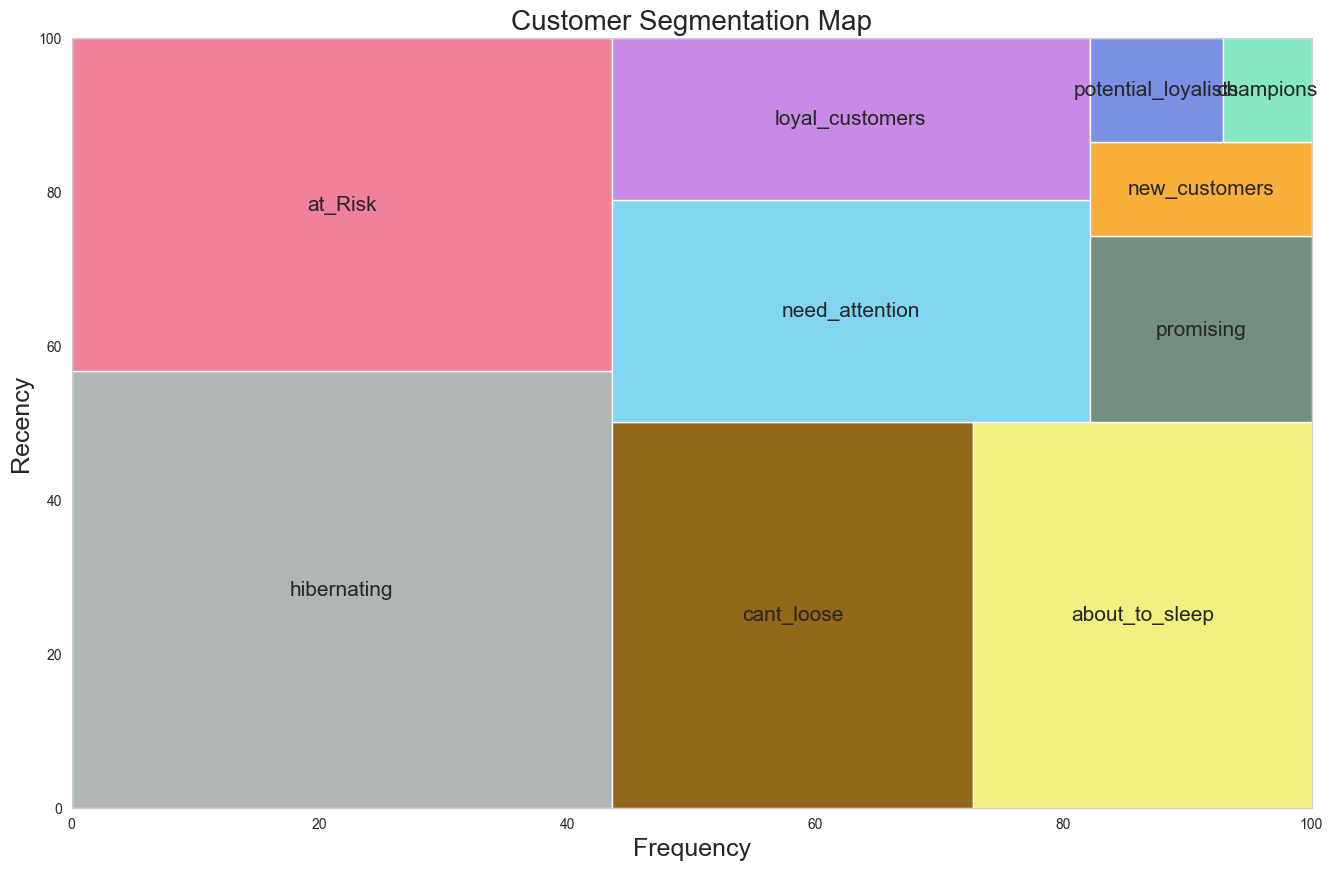

In [15]:
segments = rfm["segment"].value_counts().sort_values(ascending=False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(
    sizes=segments,
    label=[label for label in seg_map.values()],
    color=[
        "#AFB6B5",
        "#F0819A",
        "#926717",
        "#F0F081",
        "#81D5F0",
        "#C78BE5",
        "#748E80",
        "#FAAF3A",
        "#7B8FE4",
        "#86E8C0",
    ],
    pad=False,
    bar_kwargs={"alpha": 1},
    text_kwargs={"fontsize": 15},
)
plt.title("Customer Segmentation Map", fontsize=20)
plt.xlabel("Frequency", fontsize=18)
plt.ylabel("Recency", fontsize=18)
plt.show()


In [16]:
print(' RFM Model Evaluation '.center(70, '='))
X = rfm[['recency_score', 'frequency_score']]
labels = rfm['segment']
print(f'Number of Observations: {X.shape[0]}')
print(f'Number of Segments: {labels.nunique()}')
print(f'Silhouette Score: {round(silhouette_score(X, labels), 3)}')
print(f'Calinski Harabasz Score: {round(calinski_harabasz_score(X, labels), 3)}')
print(f'Davies Bouldin Score: {round(davies_bouldin_score(X, labels), 3)} \n{70*"="}')

======================== RFM Model Evaluation ========================
Number of Observations: 4339
Number of Segments: 10
Silhouette Score: 0.471
Calinski Harabasz Score: 4591.503
Davies Bouldin Score: 0.633 


In [17]:
rfm[['recency','monetary','frequency','segment']]\
.groupby('segment')\
.agg({'mean','std','max','min'})

recency                             monetary              \
                        min  max        mean        std      min         max   
segment                                                                        
about_to_sleep           34   72   53.312500  10.943474     6.20    6207.670   
at_Risk                  73  374  153.785835  68.618828    52.00   11072.670   
cant_loose               73  373  132.968254  65.250378    70.02   10254.180   
champions                 1   13    6.361769   3.683300   198.23  266163.525   
hibernating              73  374  217.605042  92.013560     3.75    9182.345   
loyal_customers          15   72   33.608059  15.577050    36.56  120210.355   
need_attention           34   72   52.427807  11.552074     6.90    4353.830   
new_customers             1   13    7.428571   3.902112    89.94     848.550   
potential_loyalists       1   33   17.398760   9.338808    20.80    4628.750   
promising                15   33   23.421053   5.238115     0.00    1491.720   

                                               frequency                  \
                            mean           std       min  max       mean   
segment                                                                    
about_to_sleep        469.058097    533.161343         1    2   1.161932   
at_Risk               938.458341    943.170824         2    6   2.878583   
cant_loose           2646.822540   2008.352354         6   34   8.380952   
champions            6498.612978  18366.105822         3  210  12.417062   
hibernating           398.573036    553.714975         1    2   1.101774   
loyal_customers      2752.519574   5405.787839         3   63   6.479853   
need_attention        847.657086    732.298552         2    3   2.326203   
new_customers         314.883690    174.620952         1    1   1.000000   
potential_loyalists   674.628357    601.746293         1    3   2.010331   
promising             282.617158    224.363976         1    1   1.000000   

                                
                           std  
segment                         
about_to_sleep        0.368913  
at_Risk               0.954415  
cant_loose            4.289630  
champions            16.476484  
hibernating           0.302492  
loyal_customers       4.545669  
need_attention        0.470081  
new_customers         0.000000  
potential_loyalists   0.651401  
promising             0.000000

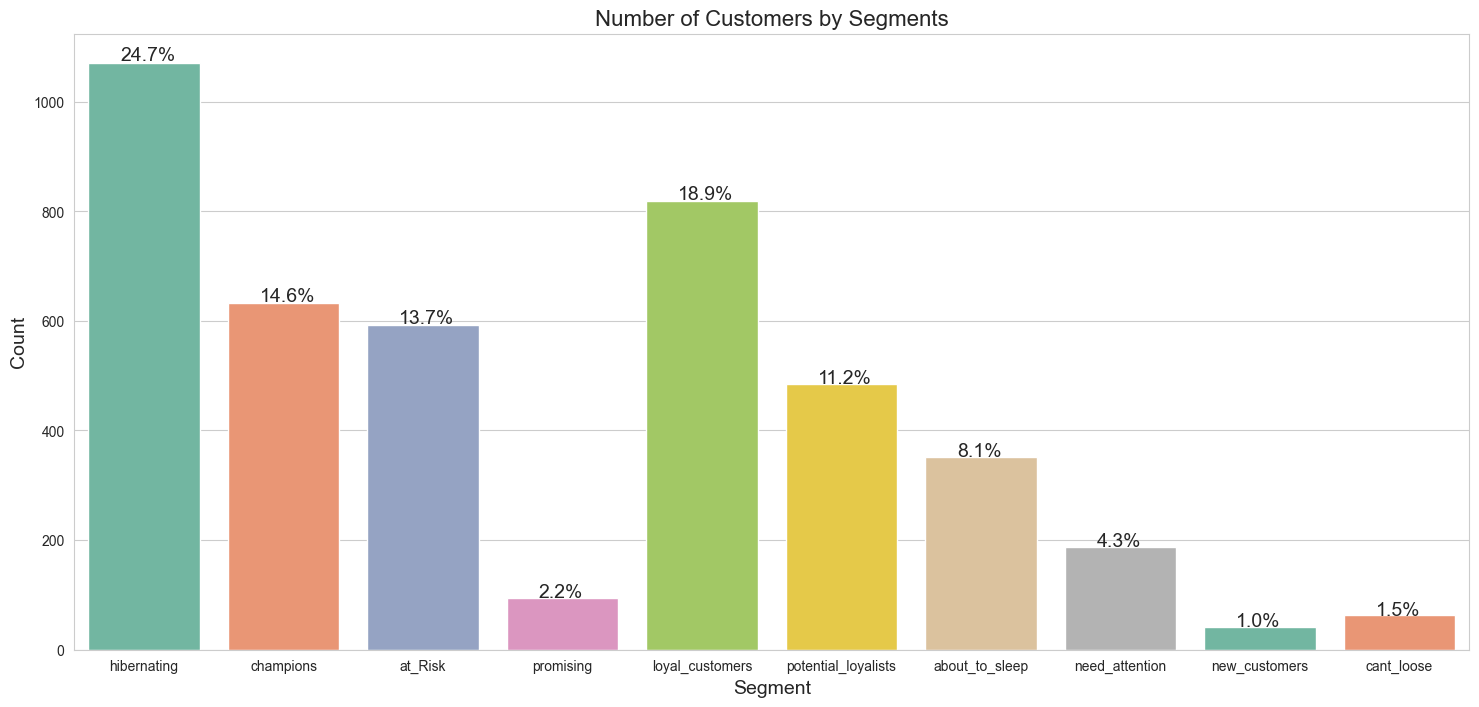

In [18]:
plt.figure(figsize = (18, 8))
ax = sns.countplot(data = rfm,
                   x = 'segment',
                   palette = palette)
total = len(rfm.segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 14)
plt.title('Number of Customers by Segments', size = 16)
plt.xlabel('Segment', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()

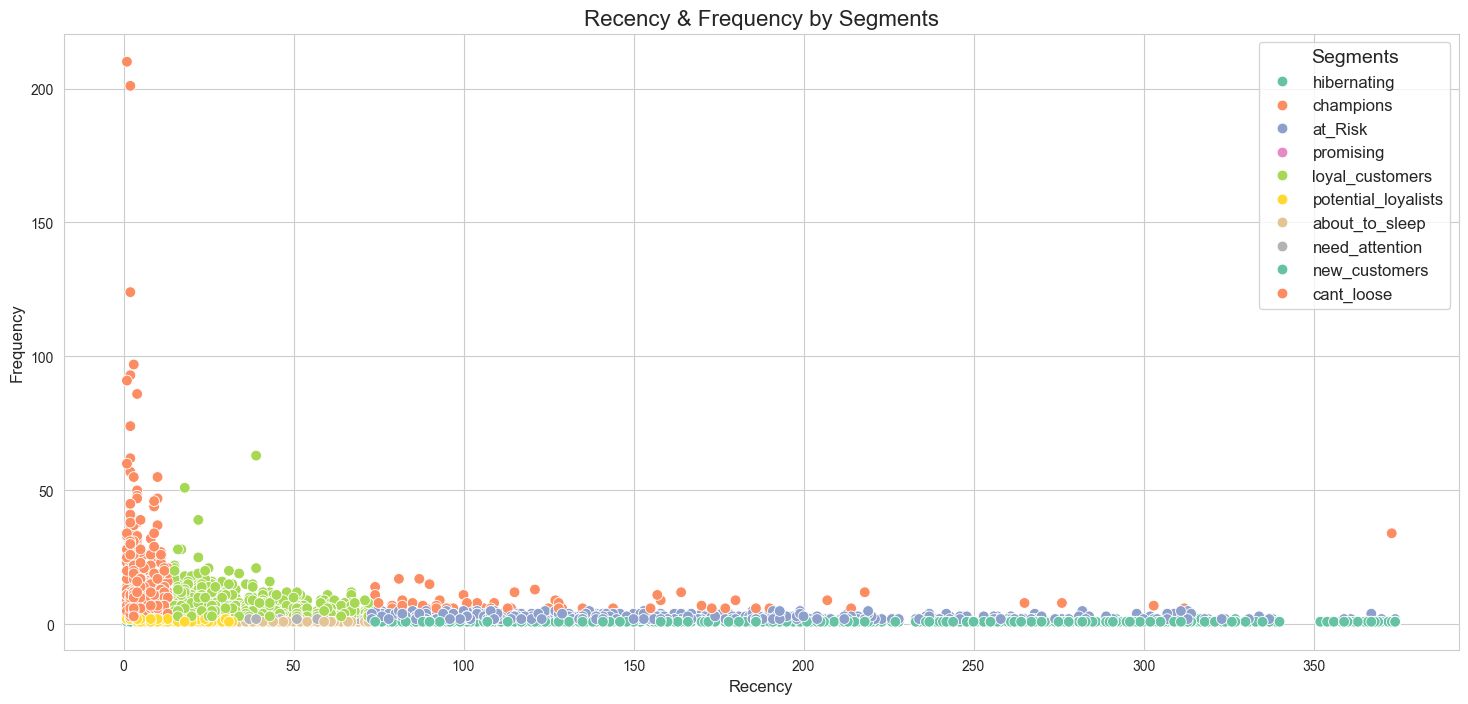

In [19]:
plt.figure(figsize=(18, 8))
sns.scatterplot(
    data=rfm, x="recency", y="frequency", hue="segment", palette=palette, s=60
)
plt.title("Recency & Frequency by Segments", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Frequency", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Segments", title_fontsize=14)
plt.show()

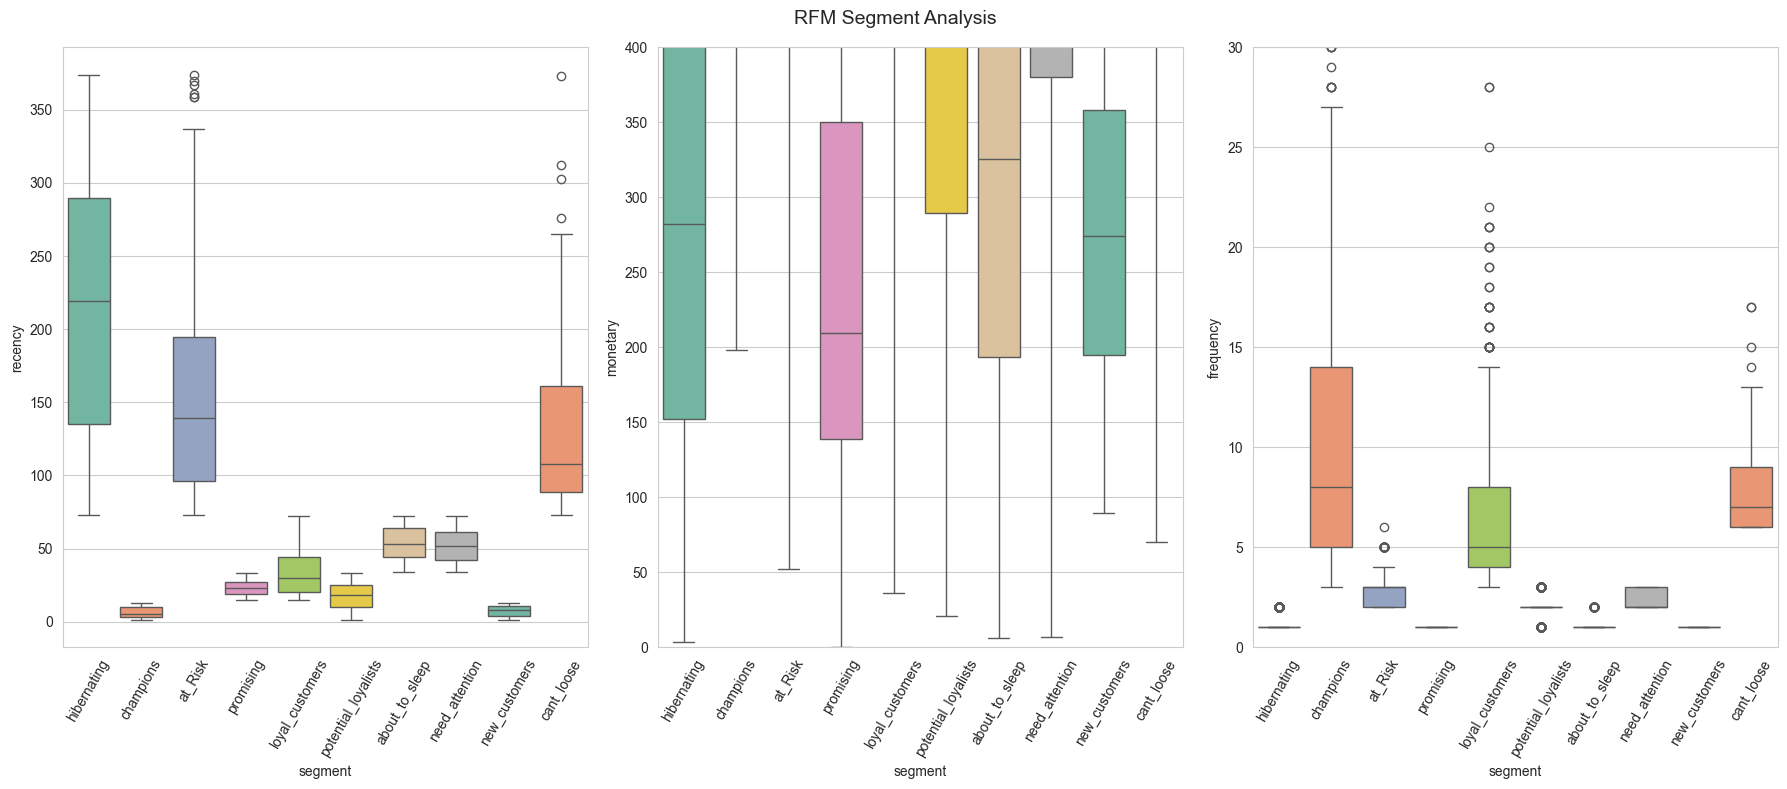

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
fig.suptitle("RFM Segment Analysis", size=14)
feature_list = ["recency", "monetary", "frequency"]
for idx, col in enumerate(feature_list):
    sns.boxplot(
        ax=axes[idx], data=rfm, x="segment", y=feature_list[idx], palette=palette
    )
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=60)
    if idx == 1:
        axes[idx].set_ylim([0, 400])
    if idx == 2:
        axes[idx].set_ylim([0, 30])
plt.tight_layout()
plt.show()

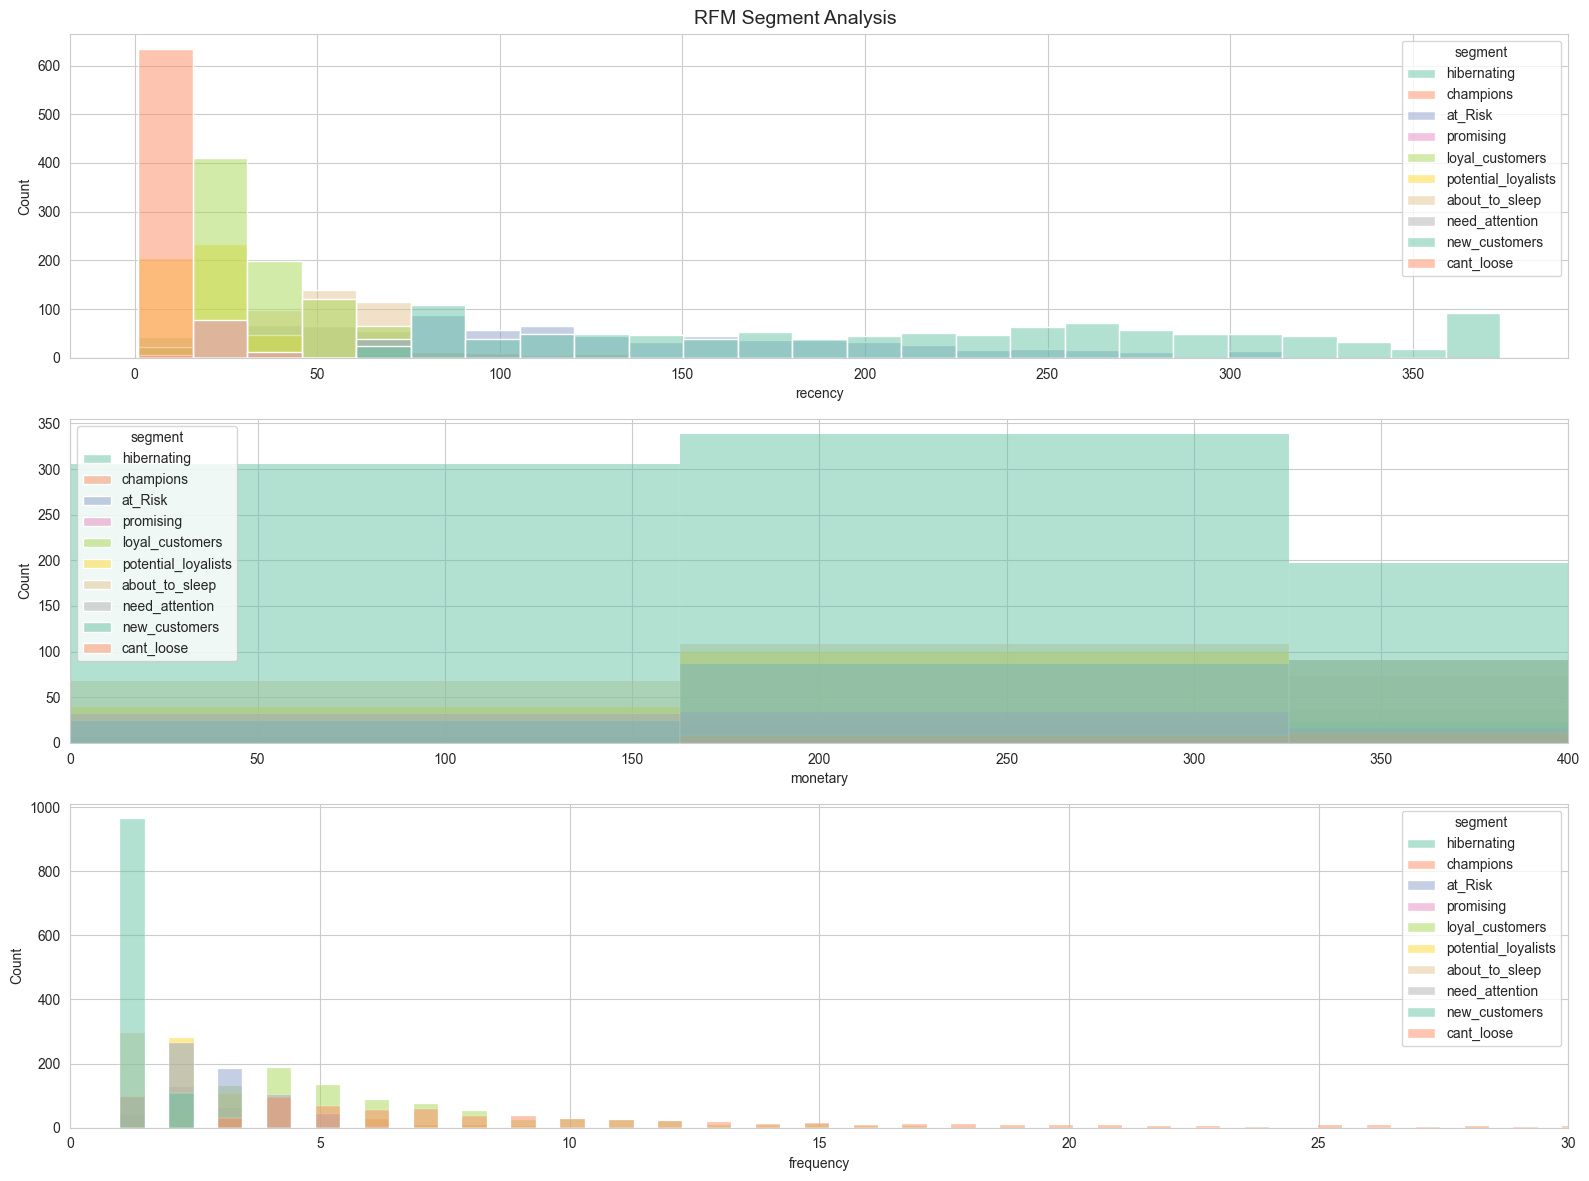

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('RFM Segment Analysis', size = 14)
feature_list = ['recency', 'monetary', 'frequency']
for idx, col in enumerate(feature_list):
    sns.histplot(ax = axes[idx], data = rfm,
                 hue = 'segment', x = feature_list[idx],
                 palette= palette)
    if idx == 1:
        axes[idx].set_xlim([0, 400])
    if idx == 2:
        axes[idx].set_xlim([0, 30])
plt.tight_layout()
plt.show()

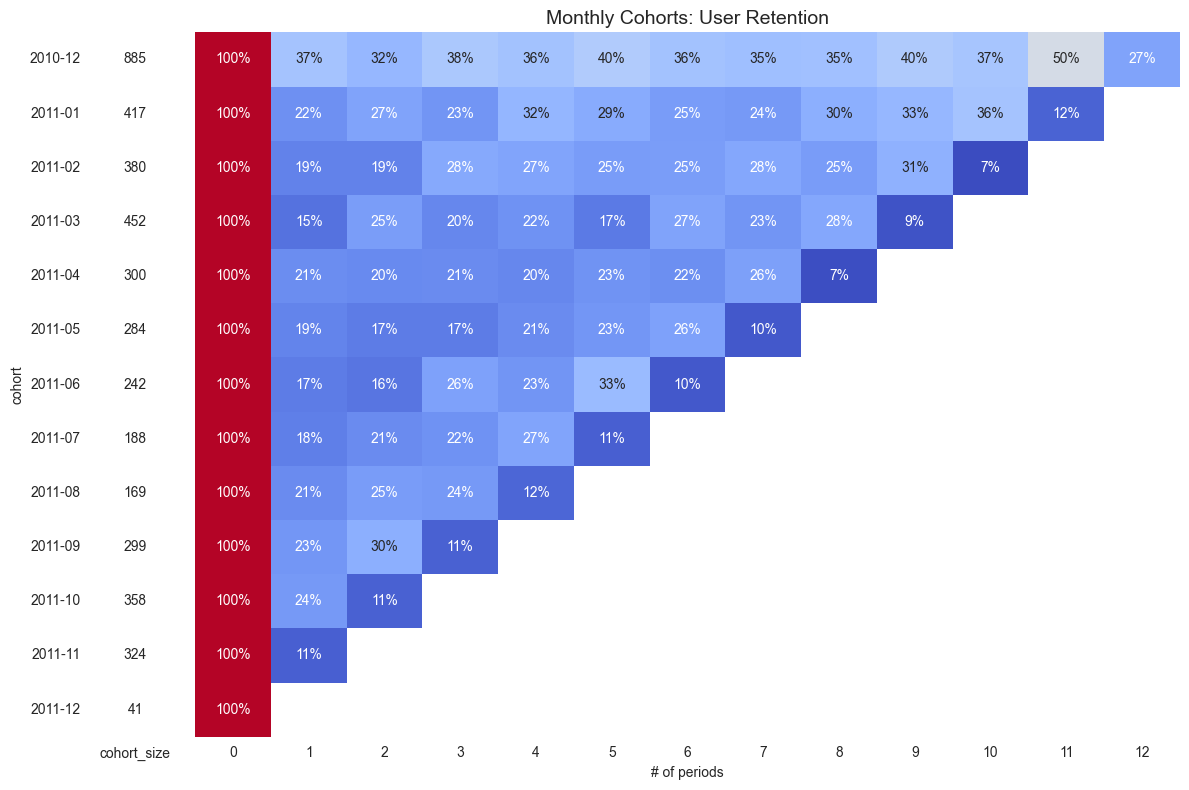

In [22]:
def CohortAnalysis(dataframe):

    data = dataframe.copy()
    data = data[["CustomerID", "InvoiceNo", "InvoiceDate"]].drop_duplicates()
    data["order_month"] = data["InvoiceDate"].dt.to_period("M")
    data["cohort"] = (
        data.groupby("CustomerID")["InvoiceDate"].transform("min").dt.to_period("M")
    )
    cohort_data = (
        data.groupby(["cohort", "order_month"])
        .agg(n_customers=("CustomerID", "nunique"))
        .reset_index(drop=False)
    )
    cohort_data["period_number"] = (cohort_data.order_month - cohort_data.cohort).apply(
        attrgetter("n")
    )
    cohort_pivot = cohort_data.pivot_table(
        index="cohort", columns="period_number", values="n_customers"
    )
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(
            1, 2, figsize=(12, 8), sharey=True, gridspec_kw={"width_ratios": [1, 11]}
        )
        sns.heatmap(
            retention_matrix,
            mask=retention_matrix.isnull(),
            annot=True,
            cbar=False,
            fmt=".0%",
            cmap="coolwarm",
            ax=ax[1],
        )
        ax[1].set_title("Monthly Cohorts: User Retention", fontsize=14)
        ax[1].set(xlabel="# of periods", ylabel="")
        white_cmap = mcolors.ListedColormap(["white"])
        sns.heatmap(
            pd.DataFrame(cohort_size).rename(columns={0: "cohort_size"}),
            annot=True,
            cbar=False,
            fmt="g",
            cmap=white_cmap,
            ax=ax[0],
        )
        fig.tight_layout()
    
CohortAnalysis(df)

In [23]:
cltv_df = df.groupby("CustomerID").agg(
    {
        "InvoiceDate": [
            lambda x: (x.max() - x.min()).days,
            lambda x: (today_date - x.min()).days,
        ],
        "InvoiceNo": "nunique",
        "TotalPrice": "sum",
    }
)

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ["recency", "T", "frequency", "monetary"]
cltv_df.head()

,recency,T,frequency,monetary
CustomerID,,,,
12346,0,326,1,310.44
12347,365,368,7,4310.00
12348,282,359,4,1770.78
12349,0,19,1,1491.72
12350,0,311,1,331.46
